In [22]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import heapq
import pandas as pd

In [23]:
img = cv.imread('../../../data/tibia_fibula_fracture/fracture/0.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
dns = cv.fastNlMeansDenoising(gray, None, 7, 21)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(dns)

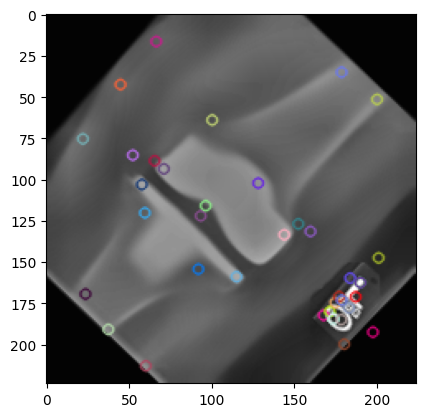

In [24]:
sift = cv.SIFT_create()
kp = sift.detect(cl1,None)

img=cv.drawKeypoints(cl1,kp,img)
plt.imshow(img)

In [25]:
def load_images_from_folder(folder, image_files):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        for cat in os.listdir(path):
            if cat in image_files:
                img = cv.imread(path + "/" + cat)
                if img is not None:
                    category.append((cat, img))
        images[filename] = category
    return images

In [26]:
def sift_features(images):
    descriptor_list = []
    sift = cv.SIFT_create()
    for key,value in images.items():
        for cat, img in value:
            kp, des = sift.detectAndCompute(img,None)
            if des is not None:
                descriptor_list.append((cat, des, key))

    descriptors=descriptor_list[0][1]
    for image_path,descriptor,label in descriptor_list[1:]:
        descriptors=np.vstack((descriptors,descriptor))
    return descriptors, descriptor_list

In [27]:
train = pd.read_csv("../../../method-2/classification/fibula/train.csv")[["image_file", "label"]]
test = pd.read_csv("../../../method-2/classification/fibula/test.csv")[["image_file", "label"]]
valid = pd.read_csv("../../../method-2/classification/fibula/valid.csv")[["image_file", "label"]]

In [28]:
dir = '../../../data/tibia_fibula_fracture'
train_image_files = train['image_file'].values
test_image_files = test['image_file'].values
valid_image_files = valid['image_file'].values

In [29]:
from scipy.cluster.vq import kmeans,vq

train_images = load_images_from_folder(dir, train_image_files)
descriptors, descriptor_list = sift_features(train_images)
k=200
voc,variance=kmeans(descriptors.astype(float),k,1)

im_features=np.zeros((len(descriptor_list),k),"float32")
for i in range(len(descriptor_list)):
    words,distance=vq(descriptor_list[i][1],voc)
    for w in words:
        im_features[i][w]+=1


In [30]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

In [31]:
feature_df = pd.DataFrame(im_features).assign(image_file = list(zip(*descriptor_list))[0], label = list(zip(*descriptor_list))[2])
feature_df['label'] = feature_df['label'].replace({'fracture': 1, 'normal': 0})
feature_df

C:\Users\assas\AppData\Local\Temp\ipykernel_23676\2849075188.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feature_df['label'] = feature_df['label'].replace({'fracture': 1, 'normal': 0})


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,image_file,label
0,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,0.684924,-0.310073,1.052586,...,-0.249385,-0.221109,1.501324,0.0,0.0,0.0,0.0,0.0,0.png,1
1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,1.png,1
2,-0.223978,-0.289540,-0.293326,2.561446,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,1.052586,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,10.png,1
3,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,100.png,1
4,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,1005.png,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,1.832999,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,89.png,0
1245,1.832999,-0.289540,-0.293326,-0.247374,-0.345317,1.227630,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,9.png,0
1246,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,1.052586,...,-0.249385,-0.221109,1.501324,0.0,0.0,0.0,0.0,0.0,90.png,0
1247,-0.223978,1.474538,3.583538,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,91.png,0


In [32]:
train = train.merge(feature_df, on=["image_file", "label"])
X_train = train.drop(columns=["image_file", "label"])
y_train = train["label"]
train

,image_file,label,0,1,2,3,4,5,6,7,...,190,191,192,193,194,195,196,197,198,199
0,1997.png,1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
1,1081.png,1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
2,336.png,1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
3,636.png,1,-0.223978,-0.289540,-0.293326,2.561446,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
4,1516.png,1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,1247.png,1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
1194,43.png,0,-0.223978,-0.289540,-0.293326,-0.247374,1.157473,-0.214806,1.295868,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
1195,136.png,0,1.832999,1.474538,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,1.573059,5.784764,-0.249385,-0.221109,1.501324,0.0,0.0,0.0,0.0,0.0
1196,1154.png,1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0


In [33]:
from sklearn.svm import LinearSVC
clf=LinearSVC()
clf.fit(X_train.values,y_train.values)

c:\Users\assas\anaconda3\envs\opencv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\assas\anaconda3\envs\opencv\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [34]:
valid_images = load_images_from_folder(dir, valid_image_files)

descriptors_valid, descriptor_list_valid = sift_features(valid_images)

valid_features=np.zeros((len(descriptor_list_valid),k),"float32")
for i in range(len(descriptor_list_valid)):
    words,distance=vq(descriptor_list_valid[i][1],voc)
    for w in words:
        valid_features[i][w]+=1

In [35]:
test_images = load_images_from_folder(dir, test_image_files)

descriptors_test, descriptor_list_test = sift_features(test_images)

test_features=np.zeros((len(descriptor_list_test),k),"float32")
for i in range(len(descriptor_list_test)):
    words,distance=vq(descriptor_list_test[i][1],voc)
    for w in words:
        test_features[i][w]+=1

In [36]:
valid_features=stdslr.transform(valid_features)
test_features=stdslr.transform(test_features)

In [37]:
valid_feature_df = pd.DataFrame(valid_features).assign(image_file = list(zip(*descriptor_list_valid))[0], label = list(zip(*descriptor_list_valid))[2]).replace({'fracture': 1, 'normal': 0})
test_feature_df = pd.DataFrame(test_features).assign(image_file = list(zip(*descriptor_list_test))[0], label = list(zip(*descriptor_list_test))[2]).replace({'fracture': 1, 'normal': 0})
test_feature_df

C:\Users\assas\AppData\Local\Temp\ipykernel_23676\183336241.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  valid_feature_df = pd.DataFrame(valid_features).assign(image_file = list(zip(*descriptor_list_valid))[0], label = list(zip(*descriptor_list_valid))[2]).replace({'fracture': 1, 'normal': 0})
C:\Users\assas\AppData\Local\Temp\ipykernel_23676\183336241.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_feature_df = pd.DataFrame(test_features).assign(image_file = list(zip(*descriptor_list_test))[0], label = list(zip(*d

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,image_file,label
0,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,1.png,1
1,-0.223978,-0.289540,-0.293326,-0.247374,2.660263,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,1.501324,0.0,0.0,0.0,0.0,0.0,101.png,1
2,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,1063.png,1
3,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,1128.png,1
4,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,1.295868,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,1131.png,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,1.832999,-0.289540,-0.293326,-0.247374,2.660263,-0.214806,-0.261917,-0.165444,-0.310073,1.052586,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,73.png,0
159,-0.223978,-0.289540,3.583538,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,1.501324,0.0,0.0,0.0,0.0,0.0,75.png,0
160,1.832999,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,83.png,0
161,-0.223978,1.474538,3.583538,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,-0.310073,-0.365623,...,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0,88.png,0


In [38]:
test = test.merge(test_feature_df, on=["image_file", "label"])
valid = valid.merge(valid_feature_df, on=["image_file", "label"])

X_valid = valid.drop(columns=["image_file", "label"])
y_valid = valid["label"]

In [39]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

prediction = clf.predict(X_valid.values)
accuracy=accuracy_score(y_valid,prediction)
print(classification_report(y_valid,prediction))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.99      1.00       123

    accuracy                           0.99       134
   macro avg       0.96      1.00      0.98       134
weighted avg       0.99      0.99      0.99       134



In [40]:
test

,image_file,label,0,1,2,3,4,5,6,7,...,190,191,192,193,194,195,196,197,198,199
0,1855.png,1,-0.223978,-0.289540,-0.293326,2.561446,1.157473,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
1,1597.png,1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
2,868.png,1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,0.259740,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
3,1651.png,1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
4,1674.png,1,-0.223978,1.474538,3.583538,-0.247374,1.157473,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,1306.png,1,-0.223978,1.474538,-0.293326,-0.247374,1.157473,-0.214806,-0.261917,0.259740,...,-0.305288,-0.188920,-0.249385,0.758202,-0.329881,0.0,0.0,0.0,0.0,0.0
144,212.png,1,-0.223978,-0.289540,-0.293326,2.561446,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,1.501324,0.0,0.0,0.0,0.0,0.0
145,1979.png,1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
146,171.png,1,-0.223978,-0.289540,-0.293326,-0.247374,-0.345317,-0.214806,1.295868,-0.165444,...,-0.305288,-0.188920,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0


In [41]:
valid

,image_file,label,0,1,2,3,4,5,6,7,...,190,191,192,193,194,195,196,197,198,199
0,238.png,1,-0.223978,-0.28954,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,1.573059,-0.18892,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
1,1985.png,1,-0.223978,-0.28954,1.645106,2.561446,-0.345317,-0.214806,-0.261917,-0.165444,...,1.573059,-0.18892,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
2,1751.png,1,-0.223978,-0.28954,-0.293326,-0.247374,1.157473,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.18892,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
3,1441.png,1,-0.223978,-0.28954,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.18892,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
4,699.png,1,-0.223978,-0.28954,-0.293326,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.18892,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,209.png,1,-0.223978,-0.28954,1.645106,-0.247374,-0.345317,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.18892,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
130,966.png,1,-0.223978,-0.28954,-0.293326,-0.247374,1.157473,-0.214806,-0.261917,-0.165444,...,-0.305288,-0.18892,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
131,1184.png,1,-0.223978,-0.28954,-0.293326,-0.247374,-0.345317,1.227630,-0.261917,-0.165444,...,-0.305288,-0.18892,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0
132,657.png,1,-0.223978,-0.28954,-0.293326,-0.247374,1.157473,-0.214806,1.295868,-0.165444,...,3.451405,-0.18892,-0.249385,-0.221109,-0.329881,0.0,0.0,0.0,0.0,0.0


In [42]:
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)
valid.to_csv("valid.csv", index=False)